In [ ]:

import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import pickle
import torch
import lightning

from tqdm import tqdm
from itertools import combinations

from mlcolvar.cvs import BaseCV
from mlcolvar.core.transform import Transform
from mlcolvar.core import FeedForward, Normalization

np.bool = np.bool_

CUDA_DEVICE = 0
blue = (70 / 255, 110 / 255, 250 / 255)
colors = ['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'brown', 'magenta']

# INPUT_DIM = 45
# MLCV_DIM = 1
# TICA_SWITCH = True
# dim_normalization = False
# date = "0811_162324"
# date = "0812_125447" # 5k
# date = "0816_171833" # 50k
# molecule = "CLN025"

MLCV_DIM = 1
INPUT_DIM = 190
TICA_SWITCH = False
molecule = "2JOF"
date = "0812_125552"
dim_normalization = False

save_path  = f"/home/shpark/prj-mlcv/lib/bioemu/model/{date}/mlcv_model.pt"

# Load

In [12]:
# Model class definition

class DIM_NORMALIZATION(Transform):
    def __init__(
        self,
        feature_dim = 1
    ):
        super().__init__(in_features=feature_dim, out_features=feature_dim)
        self.register_buffer("feature_dim", torch.tensor(feature_dim))
        
    def forward(self, x):
        x = torch.nn.functional.normalize(x, dim=-1)
        return x

class MLCV(BaseCV, lightning.LightningModule):
    BLOCKS = ["norm_in", "encoder",]

    def __init__(
        self,
        mlcv_dim: int,
        encoder_layers: list,
        dim_normalization: bool = False,
        options: dict = None,
        **kwargs,
    ):
        super().__init__(in_features=encoder_layers[0], out_features=encoder_layers[-1], **kwargs)
        # ======= OPTIONS =======
        options = self.parse_options(options)
        
        # ======= BLOCKS =======
        # initialize norm_in
        o = "norm_in"
        if (options[o] is not False) and (options[o] is not None):
            self.norm_in = Normalization(self.in_features, **options[o])

        # initialize encoder
        o = "encoder"
        self.encoder = FeedForward(encoder_layers, **options[o])
        if dim_normalization:
        	self.postprocessing = DIM_NORMALIZATION(mlcv_dim)


In [13]:
# Load model

model_state = torch.load(save_path)
print(model_state.keys())

mlcv_state_dict = model_state["mlcv_state_dict"]
encoder_layers = [INPUT_DIM, 100, 100, MLCV_DIM]
options = {
	"encoder": {
		"activation": "tanh",
		"dropout": [0.1, 0.1, 0.1]
	},
	"norm_in": {
	},
}
mlcv_model = MLCV(
    mlcv_dim = MLCV_DIM,
	encoder_layers = encoder_layers,
	dim_normalization = dim_normalization,
	options = options
)

mlcv_model.load_state_dict(mlcv_state_dict)
mlcv_model.eval()
print(mlcv_model)

dict_keys(['mlcv_state_dict'])
MLCV(
  (norm_in): Normalization(in_features=190, out_features=190, mode=mean_std)
  (encoder): FeedForward(
    (nn): Sequential(
      (0): Linear(in_features=190, out_features=100, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): Tanh()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=100, out_features=1, bias=True)
      (7): Dropout(p=0.1, inplace=False)
    )
  )
)


In [14]:
# TICA Model
lag = 10

class TICA_WRAPPER:
    """TICA wrapper for coordinate transformation."""
    def __init__(self, tica_model_path, pdb_path, tica_switch: bool = False):
        with open(tica_model_path, 'rb') as f:
            self.tica_model = pickle.load(f)
        self.pdb = md.load(pdb_path)
        self.ca_resid_pair = np.array(
            [(a.index, b.index) for a, b in combinations(list(self.pdb.topology.residues), 2)]
        )
        self.tica_switch = tica_switch
        print(f"Loaded TICA model: {self.tica_model}")

    def transform(self, cad_data: np.ndarray):
        if self.tica_switch:
            cad_data = (1 - np.power(cad_data / 0.8, 6)) / (1 - np.power(cad_data / 0.8, 12))
        tica_coord = self.tica_model.transform(cad_data)
        return tica_coord

    def pos2cad(self, pos_data: np.ndarray):
        self.pdb.xyz = pos_data
        ca_pair_distances, _ = md.compute_contacts(
            self.pdb, scheme="ca", contacts=self.ca_resid_pair, periodic=False
        )
        return ca_pair_distances

if TICA_SWITCH:
	tica_model_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_tica_model_switch_lag{lag}.pkl"
else:
	tica_model_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_tica_model_lag{lag}.pkl"         
tica_wrapper = TICA_WRAPPER(
	tica_model_path=tica_model_path,
	pdb_path=f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_from_mae.pdb",
	tica_switch=TICA_SWITCH
)

Loaded TICA model: TICA(commute_map=False, dim=2, epsilon=1e-06, kinetic_map=True, lag=10,
   ncov_max=inf, reversible=True, skip=0, stride=1, var_cutoff=0.95,
   weights=None)


In [15]:
# Committor model
committor_path = "./committor.pt"
committor_model = torch.jit.load(committor_path, map_location=f"cuda:{CUDA_DEVICE}")
print(committor_model)

RecursiveScriptModule(
  original_name=NN_committor_guess
  (nn): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=Tanh)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=Tanh)
    (4): RecursiveScriptModule(original_name=Linear)
    (5): RecursiveScriptModule(original_name=CustomActivation)
  )
)


In [16]:
# Load data
pdb_path = f"/home/shpark/prj-mlcv/lib/DESRES/data/{molecule}/{molecule}_from_mae.pdb"
pos_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-pos.pt"
cad_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-cad.pt"
pos_torch = torch.load(pos_path)
cad_torch = torch.load(cad_path)
print(f"Position shape: {pos_torch.shape}")
print(f"CAD shape: {cad_torch.shape}")

if molecule == "CLN025":
	bond_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-bond_num_distance.pt"
	label_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-label_distance.pt"
	bond_torch = torch.load(bond_path)
	label_torch = torch.load(label_path)
	print(bond_torch.shape)
	print(label_torch.shape)

Position shape: torch.Size([1044000, 272, 3])
CAD shape: torch.Size([1044000, 190])


# Analysis

## CV

In [17]:
cad_data = cad_torch.numpy()
cv = mlcv_model(torch.from_numpy(cad_data))
cv = cv.detach().cpu().numpy()

print(cv.shape)
print(cv.max(), cv.min())
MLCV_DIM = cv.shape[1]

(1044000, 1)
10.398798 -10.108323


In [18]:
# Normalization CV
cv_normalized = np.zeros_like(cv)

for cv_dim in range(MLCV_DIM):
	cv_dim_val = cv[:, cv_dim]
	cv_range_min, cv_range_max = cv_dim_val.min(), cv_dim_val.max()
	cv_range_mean = (cv_range_min + cv_range_max) / 2.0
	cv_range = (cv_range_max - cv_range_min) / 2.0
	cv_normalized[:, cv_dim] = (cv_dim_val - cv_range_mean) / cv_range

	print(f"< CV {cv_dim} >")
	print(f"  range_min: {cv_range_min:.4f}")
	print(f"  range_max: {cv_range_max:.4f}")
	print(f"  range_mean: {cv_range_mean:.4f}")

cv = cv_normalized

for cv_dim in range(MLCV_DIM):
	cv_dim_val = cv[:, cv_dim]
	cv_range_min, cv_range_max = cv_dim_val.min(), cv_dim_val.max()
	cv_range_mean = (cv_range_min + cv_range_max) / 2.0
	cv_range = (cv_range_max - cv_range_min) / 2.0
	print(f"< Normalized CV {cv_dim} >")
	print(f"  range_min: {cv_range_min:.4f}")
	print(f"  range_max: {cv_range_max:.4f}")
	print(f"  range_mean: {cv_range_mean:.4f}")

< CV 0 >
  range_min: -10.1083
  range_max: 10.3988
  range_mean: 0.1452
< Normalized CV 0 >
  range_min: -1.0000
  range_max: 1.0000
  range_mean: 0.0000


In [19]:
cv = -cv

## TICA and CVs

In [14]:
# 2D TICA coordinates
tica_data = tica_wrapper.transform(cad_data)
x = tica_data[:, 0]
y = tica_data[:, 1]

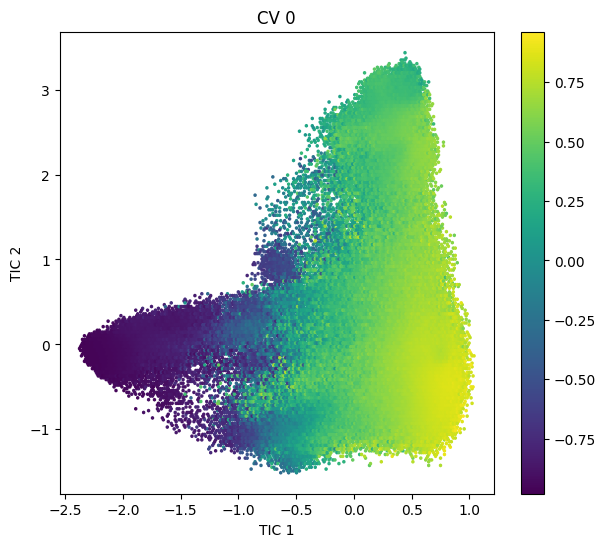

In [15]:
# 2D TICA plot
for cv_dim in range(MLCV_DIM):
	fig = plt.figure(figsize=(7, 6))
	ax = fig.add_subplot(111)
	hb = ax.hexbin(
		x, y, C=cv[:, cv_dim],
		gridsize=200,                     # controls resolution
		reduce_C_function=np.mean,       # compute average per hexagon
		cmap='viridis',                  # colormap
	)
	plt.colorbar(hb)
	plt.xlabel("TIC 1")
	plt.ylabel("TIC 2")
	plt.title(f"CV {cv_dim}")
	plt.savefig(f"/home/shpark/prj-mlcv/lib/bioemu/model/{date}/tica-cv{cv_dim}.png")
	plt.show()

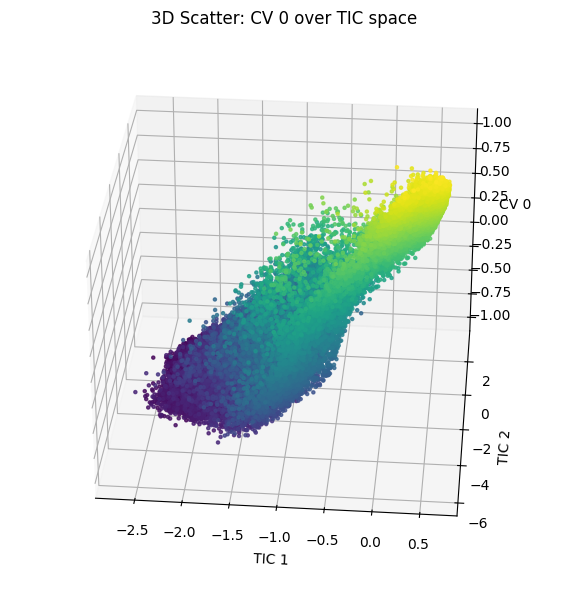

In [59]:
# 3D scatter plot
for cv_dim in range(MLCV_DIM):
	z = cv[:, cv_dim]

	fig = plt.figure(figsize=(8, 6))
	ax = fig.add_subplot(111, projection='3d')

	sc = ax.scatter(x, y, z, c=z, cmap='viridis', s=5, alpha=0.8)

	ax.set_xlabel('TIC 1')
	ax.set_ylabel('TIC 2')
	ax.set_zlabel(f'CV {cv_dim}')
	ax.set_title(f'3D Scatter: CV {cv_dim} over TIC space')
	ax.view_init(azim=-85)
	# fig.colorbar(sc, ax=ax, label='CV Value')

	plt.tight_layout()
	plt.show()

In [60]:
# Interactive 3D TICA plot

# # Loop over each CV dimension
# for cv_dim in range(MLCV_DIM):
#     z = cv[:, cv_dim]

#     fig = go.Figure(
#         data=go.Scatter3d(
#             x=x,
#             y=y,
#             z=z,
#             mode='markers',
#             marker=dict(
#                 size=3,
#                 color=z,
#                 colorscale='Viridis',
#                 colorbar=dict(title=f'CV {cv_dim}'),
#                 opacity=0.8
#             )
#         )
#     )

#     fig.update_layout(
#         scene=dict(
#             xaxis_title='TIC 1',
#             yaxis_title='TIC 2',
#             zaxis_title=f'CV {cv_dim}',
# 			aspectmode='manual',
#         	aspectratio=dict(x=1, y=1, z=1)
#         ),
#         title=f'CV {cv_dim} in TICA Space',
#         margin=dict(l=0, r=0, b=0, t=30)
#     )

#     fig.show()

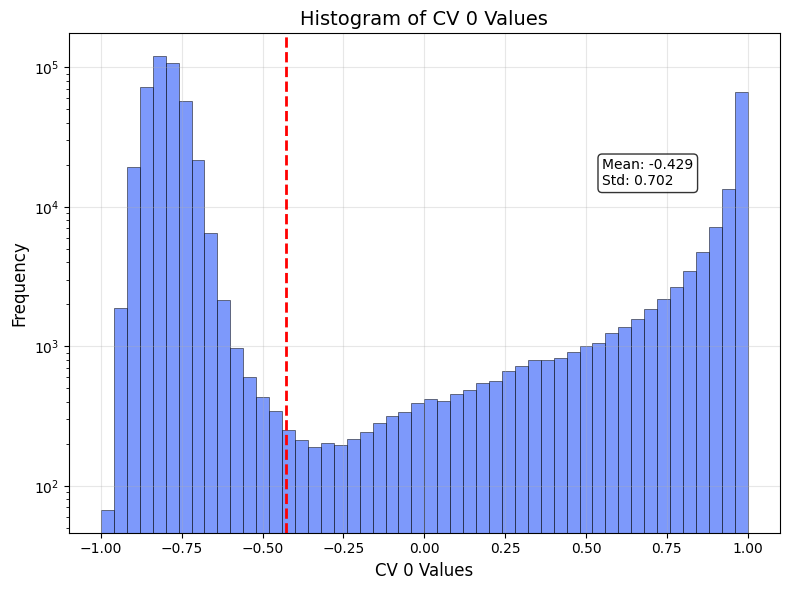

CV 0 Statistics:
  Total samples: 530000
  Mean: -0.428770
  Standard deviation: 0.701657


In [61]:
# CV Histogram

n_bins = 50

plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
counts, bins, patches = ax.hist(
    cv_dim_val,
    bins=n_bins,
    alpha=0.7,
    color=blue,
    edgecolor='black',
    linewidth=0.5,
    log=True,
)

# Add statistics text
mean_val = np.mean(cv_dim_val)
std_val = np.std(cv_dim_val)
min_val = np.min(cv_dim_val)
max_val = np.max(cv_dim_val)

stats_text = f'Mean: {mean_val:.3f}\nStd: {std_val:.3f}'
ax.text(0.75, 0.75, stats_text, transform=ax.transAxes, 
		bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
		verticalalignment='top', fontsize=10)
ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')

ax.set_xlabel(f'CV {cv_dim} Values', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title(f'Histogram of CV {cv_dim} Values', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"CV {cv_dim} Statistics:")
print(f"  Total samples: {len(cv_dim_val)}")
print(f"  Mean: {mean_val:.6f}")
print(f"  Standard deviation: {std_val:.6f}")

## Bond number and CVs

In [ ]:
bond_num_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-bond_num-distance_angle.pt"
bond_num_torch = torch.load(bond_num_path)
bond_num = bond_num_torch.numpy()

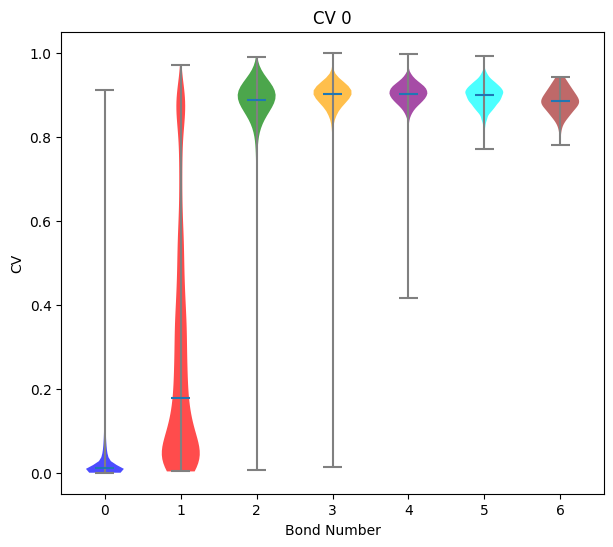

In [ ]:
# Violin plot for bond number and CV

for cv_dim in range(MLCV_DIM):
	fig = plt.figure(figsize=(7, 6))
	ax = fig.add_subplot(111)
	cv_dim_val = cv[:, cv_dim]
	range_min, range_max = cv_dim_val.min(), cv_dim_val.max()
	x = (cv_dim_val - range_min) / (range_max - range_min)
	y = bond_num
	grouped = [x[y == i] for i in sorted(np.unique(y))]
	violin = plt.violinplot(grouped, positions=sorted(np.unique(y)), showmeans=False, showmedians=True)
	for i, body in enumerate(violin['bodies']):
		body.set_facecolor(colors[i % len(colors)])
		body.set_alpha(0.7)

	violin['cbars'].set_edgecolor('gray')
	violin['cmaxes'].set_edgecolor('gray')
	violin['cmins'].set_edgecolor('gray')

	ax.set_xlabel("Bond Number")
	ax.set_ylabel("CV")
	ax.set_title(f"CV {cv_dim}")
	plt.show()


## Committor and CVs

In [64]:
from scipy.stats import pearsonr

committor_value = committor_model(cad_torch.to(CUDA_DEVICE))
committor_value = committor_value.cpu().detach().numpy().flatten()

In [65]:
# Pearson correlation between committor values and CV values
from scipy.stats import pearsonr
import pandas as pd

print("Pearson Correlation Analysis")
print("=" * 50)

# Compute correlations for each CV dimension
correlation_results = []

for cv_dim in range(MLCV_DIM):
    cv_values = cv[:, cv_dim]
    
    # Compute Pearson correlation
    correlation, p_value = pearsonr(committor_value, cv_values)
    
    correlation_results.append({
        'CV_Dimension': cv_dim,
        'Correlation': correlation,
        'P_Value': p_value,
        'Correlation_Strength': 'Strong' if abs(correlation) > 0.7 else 'Moderate' if abs(correlation) > 0.3 else 'Weak'
    })
    
    print(f"CV {cv_dim} vs Committor:")
    print(f"  Pearson correlation: {correlation:.6f}")
    print(f"  P-value: {p_value:.2e}")
    print(f"  Correlation strength: {correlation_results[-1]['Correlation_Strength']}")
    print()

# Create a summary DataFrame
df_correlations = pd.DataFrame(correlation_results)
print("Summary Table:")
print(df_correlations.to_string(index=False))

# Additional correlations with other variables
print("\n" + "=" * 50)
print("Additional Correlations")
print("=" * 50)

# Correlation with TICA coordinates
tica_x = tica_data[:, 0]
tica_y = tica_data[:, 1]

corr_tica_x, p_tica_x = pearsonr(committor_value, tica_x)
corr_tica_y, p_tica_y = pearsonr(committor_value, tica_y)

print(f"Committor vs TICA-1: r = {corr_tica_x:.6f}, p = {p_tica_x:.2e}")
print(f"Committor vs TICA-2: r = {corr_tica_y:.6f}, p = {p_tica_y:.2e}")

# Correlation with bond number
corr_bond, p_bond = pearsonr(committor_value, bond_num)
print(f"Committor vs Bond Number: r = {corr_bond:.6f}, p = {p_bond:.2e}")

# Cross-correlations between variables
print(f"\nCross-correlations:")
for cv_dim in range(MLCV_DIM):
    cv_values = cv[:, cv_dim]
    corr_cv_tica1, p_cv_tica1 = pearsonr(cv_values, tica_x)
    corr_cv_tica2, p_cv_tica2 = pearsonr(cv_values, tica_y)
    corr_cv_bond, p_cv_bond = pearsonr(cv_values, bond_num)
    
    print(f"CV {cv_dim} vs TICA-1: r = {corr_cv_tica1:.6f}")
    print(f"CV {cv_dim} vs TICA-2: r = {corr_cv_tica2:.6f}")
    print(f"CV {cv_dim} vs Bond Number: r = {corr_cv_bond:.6f}")
    print()


Pearson Correlation Analysis
CV 0 vs Committor:
  Pearson correlation: -0.984131
  P-value: 0.00e+00
  Correlation strength: Strong

Summary Table:
 CV_Dimension  Correlation  P_Value Correlation_Strength
            0    -0.984131      0.0               Strong

Additional Correlations
Committor vs TICA-1: r = -0.983871, p = 0.00e+00
Committor vs TICA-2: r = -0.086205, p = 0.00e+00
Committor vs Bond Number: r = -0.920363, p = 0.00e+00

Cross-correlations:
CV 0 vs TICA-1: r = 0.994076
CV 0 vs TICA-2: r = 0.006761
CV 0 vs Bond Number: r = 0.920358



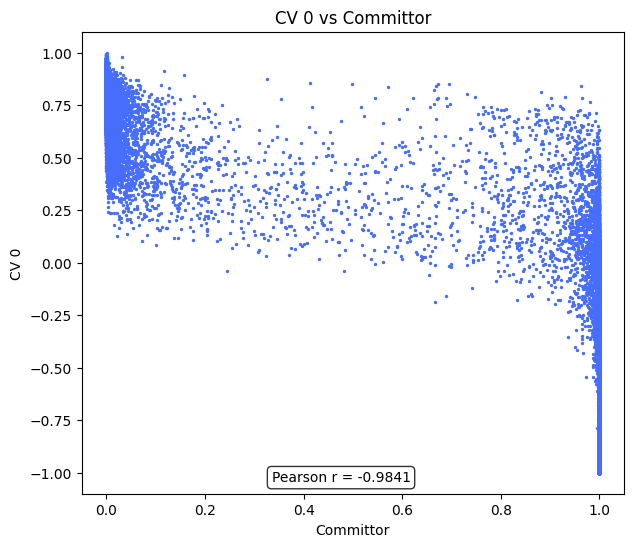

In [66]:
for cv_dim in range(MLCV_DIM):
	fig = plt.figure(figsize=(7, 6))
	ax = fig.add_subplot(111)
	ax.scatter(committor_value, cv[:, cv_dim], color=blue, s=2)
	correlation, p_value = pearsonr(committor_value, cv[:, cv_dim])
	correlation_text = f'Pearson r = {correlation:.4f}'
	ax.text(
		0.35, 0.05,
		correlation_text,
		transform=ax.transAxes, 
		bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
		verticalalignment='top', fontsize=10
	)
	ax.set_xlabel("Committor")
	ax.set_ylabel(f"CV {cv_dim}")
	ax.set_title(f"CV {cv_dim} vs Committor")
	plt.show()

## Folded state RMSD and CVs

(530000,)
(530000, 1)


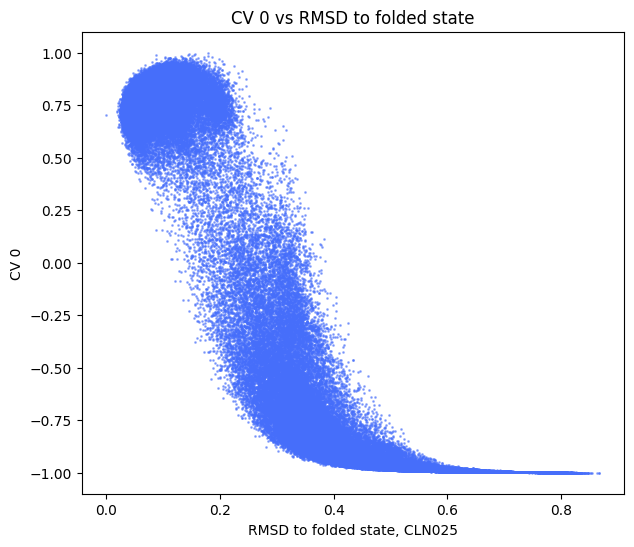

In [67]:
rmsd_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-label_rmsd.pt"
rmsd = torch.load(rmsd_path).numpy()[:530000]
print(rmsd.shape)
print(cv.shape)

for cv_dim in range(MLCV_DIM):
	fig = plt.figure(figsize=(7, 6))
	ax = fig.add_subplot(111)
	ax.scatter(
		rmsd,
		cv[:, cv_dim],
		color=blue,
		s=1,
		alpha=0.5,
	)
	ax.set_xlabel(f"RMSD to folded state, {molecule}")
	ax.set_ylabel(f"CV {cv_dim}")
	ax.set_title(f"CV {cv_dim} vs RMSD to folded state")
	plt.show()

## Secondary structure

In [7]:
dssp_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-dssp.npy"
dssp_full = np.load(dssp_path)
print(np.unique(dssp_full))
print(dssp_full.shape)
print(dssp_full[0])

[' ' 'B' 'E' 'G' 'H' 'I' 'S' 'T']
(1044000, 20)
[' ' ' ' 'H' 'H' 'H' 'H' 'H' 'H' 'T' 'T' 'H' 'H' 'H' 'H' 'T' ' ' ' ' ' '
 ' ' ' ']


In [8]:
dssp_simplified_path = f"/home/shpark/prj-mlcv/lib/DESRES/DESRES-Trajectory_{molecule}-0-protein/{molecule}-0-dssp-simplified.npy"
dssp_simplified = np.load(dssp_simplified_path)

print(np.unique(dssp_simplified))
print(dssp_simplified.shape)
print(dssp_simplified[0])

['C' 'E' 'H']
(1044000, 20)
['C' 'C' 'H' 'H' 'H' 'H' 'H' 'H' 'C' 'C' 'H' 'H' 'H' 'H' 'C' 'C' 'C' 'C'
 'C' 'C']


In [20]:
# Per-Residue Secondary Structure Violin Plots - collect data

'''
Create violin plots for each residue showing CV distribution across secondary structures
X-axis: Secondary Structure Types
Y-axis: CV Values
One plot per residue
'''

import matplotlib.pyplot as plt
from collections import defaultdict

dssp = dssp_full
# dssp = dssp_simplified
ss_types = np.unique(dssp)
print("Creating per-residue secondary structure violin plots...")
print(f"Available secondary structure types: {ss_types}")

# Collect data for each residue
residue_data = {}
min_frames_threshold = 20


for residue_idx in range(dssp.shape[1]):
	# Collect CV values for each secondary structure at this residue
	ss_cv_data = defaultdict(list)

	for cv_dim in range(MLCV_DIM):
		cv_values = cv[:, cv_dim]
		
		for frame_idx in range(dssp.shape[0]):
			ss_type = dssp[frame_idx, residue_idx]
			ss_cv_data[ss_type].append(cv_values[frame_idx])

	residue_data[residue_idx] = ss_cv_data

	# # Filter secondary structures that have enough data points
	# filtered_ss_data = {}
	# for ss_type in ss_types:
	#     if ss_type in ss_cv_data and len(ss_cv_data[ss_type]) >= min_frames_threshold:
	#         filtered_ss_data[ss_type] = ss_cv_data[ss_type]

	# # Only store residue data if it has multiple secondary structures
	# if len(filtered_ss_data) >= 2:
	#     residue_data[residue_idx] = filtered_ss_data

print(f"Found {len(residue_data)} residues with sufficient secondary structure diversity")

Creating per-residue secondary structure violin plots...
Available secondary structure types: [' ' 'B' 'E' 'G' 'H' 'I' 'S' 'T']
Found 20 residues with sufficient secondary structure diversity


Plotting per-residue secondary structure violin plots: 100%|██████████| 14/14 [00:32<00:00,  2.33s/it]


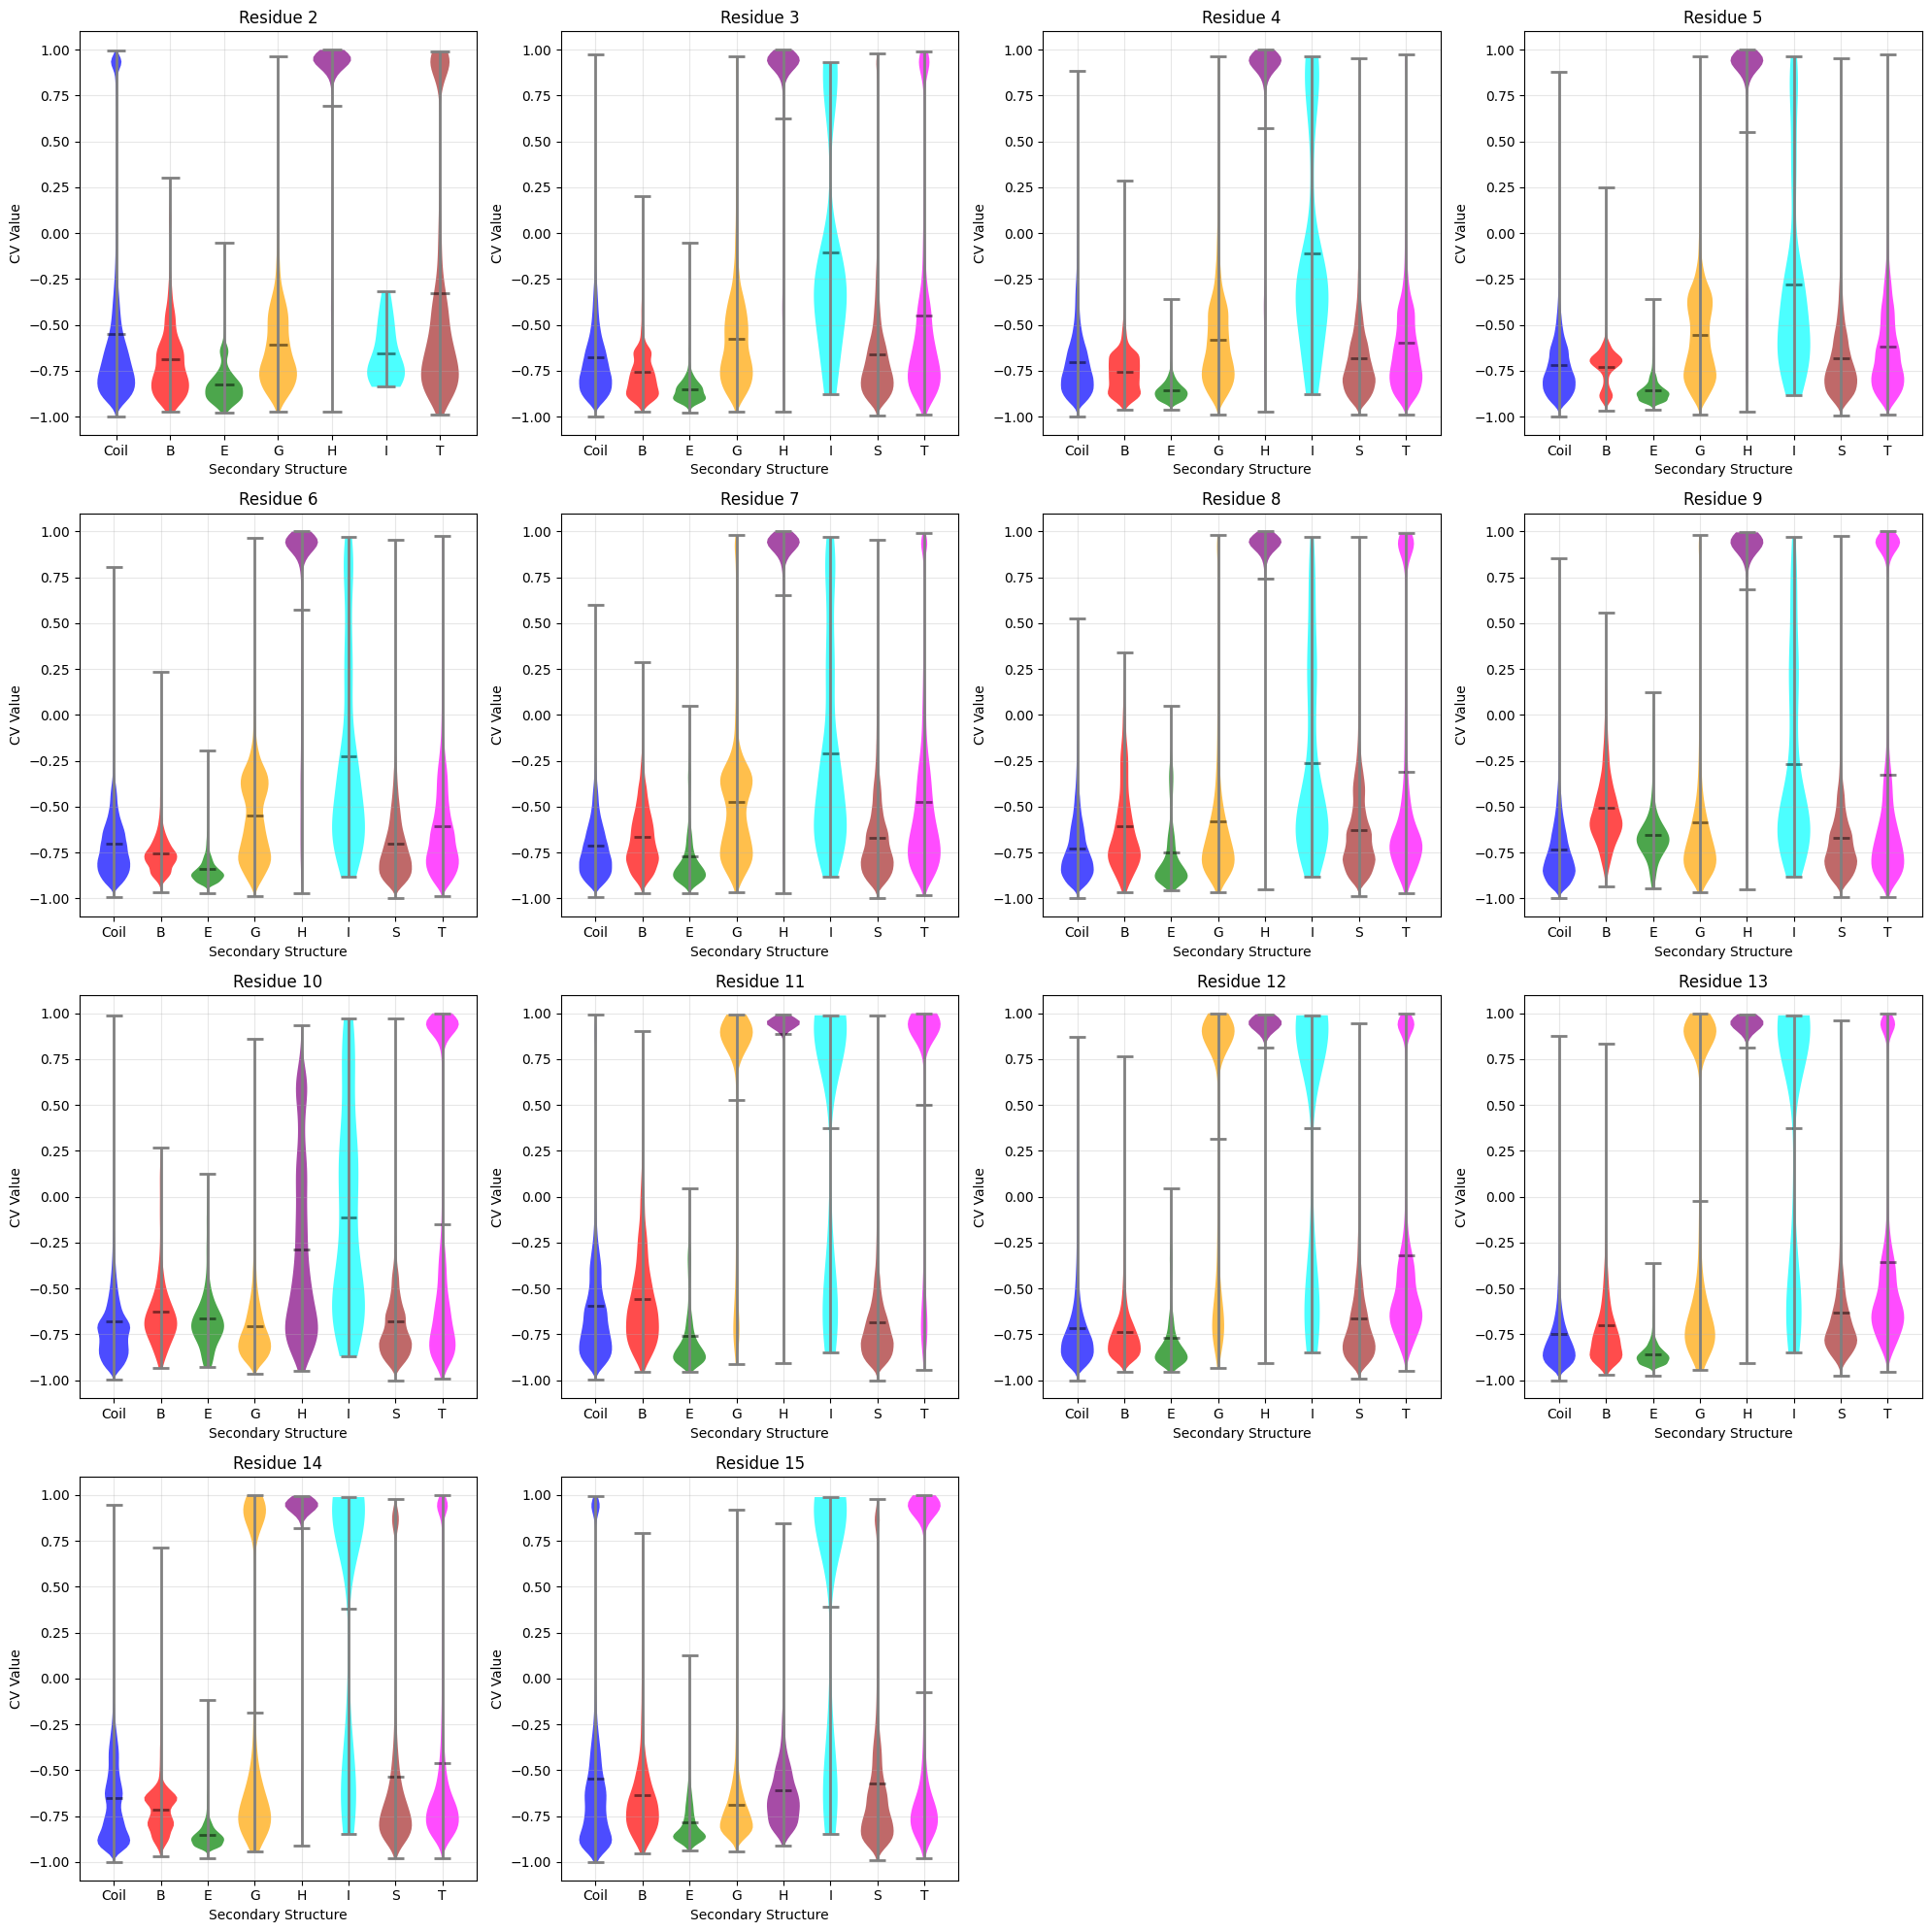


Analysis complete! Shown plots for 14 residues.


In [21]:
# Per-Residue Secondary Structure Violin Plots - plot
max_plots = 24
if molecule == "2JOF":
    selected_residues = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
else:
    raise ValueError(f"Invalid molecule: {molecule}")
# selected_residues = sorted(list(residue_data.keys()))[:max_plots]
selected_residues = selected_residues[:max_plots]

if len(selected_residues) > 0:
    # Calculate grid size
    n_cols = 4
    n_rows = (len(selected_residues) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for plot_idx, residue_idx in tqdm(
        enumerate(selected_residues),
        desc="Plotting per-residue secondary structure violin plots",
        total=len(selected_residues)
    ):
        ax = axes[plot_idx]
        ss_data = residue_data[residue_idx]
        ss_types_present = sorted(ss_data.keys())
        cv_data_list = [ss_data[ss_type] for ss_type in ss_types_present]
        
        # Create violin plot
        violin_parts = ax.violinplot(
            cv_data_list,
            positions=range(len(ss_types_present)),
            showmeans=True,
            showmedians=True,
            widths=0.7
        )
        for i, body in enumerate(violin_parts['bodies']):
            body.set_facecolor(colors[i % len(colors)])
            body.set_alpha(0.7)
        
        # Style other elements
        violin_parts['cbars'].set_edgecolor('gray')
        violin_parts['cbars'].set_linewidth(2)
        violin_parts['cbars'].set_alpha(1)
        violin_parts['cmaxes'].set_edgecolor('gray')
        violin_parts['cmaxes'].set_linewidth(2)
        violin_parts['cmaxes'].set_alpha(1)
        violin_parts['cmins'].set_edgecolor('gray')
        violin_parts['cmins'].set_linewidth(2)
        violin_parts['cmins'].set_alpha(1)
        violin_parts['cmeans'].set_edgecolor('black')
        violin_parts['cmeans'].set_linewidth(2)
        violin_parts['cmeans'].set_alpha(0.5)
        violin_parts['cmedians'].set_linewidth(0)
        
        # Customize plot
        ax.set_xlabel('Secondary Structure')
        ax.set_ylabel('CV Value')
        ax.set_title(f'Residue {residue_idx + 1}')
        ax.grid(True, alpha=0.3)
        
        # Set x-axis labels
        ss_labels = ['Coil' if ss == ' ' else ss for ss in ss_types_present]
        ax.set_xticks(range(len(ss_types_present)))
        ax.set_xticklabels(ss_labels)
    
    # Hide unused subplots
    for idx in range(len(selected_residues), len(axes)):
        axes[idx].set_visible(False)
    
    # plt.suptitle('CV Distribution by Secondary Structure for Each Residue', fontsize=20)
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics for each residue
    # print("\nDetailed Residue Statistics:")
    # print("=" * 70)
    # for residue_idx in selected_residues[:6]:  # Show stats for first 6 residues
    #     print(f"\nResidue {residue_idx}:")
    #     print("-" * 30)
    #     ss_data = residue_data[residue_idx]
    #     for ss_type in sorted(ss_data.keys()):
    #         cv_vals = ss_data[ss_type]
    #         ss_name = 'Coil' if ss_type == ' ' else f'SS-{ss_type}'
    #         print(f"  {ss_name}:")
    #         print(f"    Frames: {len(cv_vals):,}")
    #         print(f"    Mean CV: {np.mean(cv_vals):.4f}")
    #         print(f"    Std CV: {np.std(cv_vals):.4f}")
    #         print(f"    Range: [{np.min(cv_vals):.4f}, {np.max(cv_vals):.4f}]")
    
else:
    print("No residues found with sufficient secondary structure diversity for analysis.")
    print("This could mean:")
    print("- Most residues adopt only one secondary structure")
    print("- The minimum frames threshold is too high")
    print("- The protein has very stable secondary structure")

print(f"\nAnalysis complete! Shown plots for {len(selected_residues)} residues.")


In [22]:
## Summary and Key Insights

# Create a summary analysis of the most interesting findings
print("🎯 KEY INSIGHTS FROM SECONDARY STRUCTURE ANALYSIS:")
print("=" * 60)

if len(residue_data) > 0:
    # Find residues with highest CV variance across secondary structures
    variance_analysis = []
    
    for residue_idx, ss_data in residue_data.items():
        if len(ss_data) >= 2:  # Need at least 2 SS types
            # Calculate variance in CV means across secondary structures
            ss_means = [np.mean(cv_vals) for cv_vals in ss_data.values()]
            cv_variance_across_ss = np.var(ss_means)
            
            variance_analysis.append({
                'residue': residue_idx,
                'variance': cv_variance_across_ss,
                'ss_count': len(ss_data),
                'ss_types': list(ss_data.keys()),
                'mean_range': max(ss_means) - min(ss_means)
            })
    
    # Sort by variance (highest first)
    variance_analysis.sort(key=lambda x: x['variance'], reverse=True)
    
    print("\n📊 RESIDUES WITH HIGHEST CV SENSITIVITY TO SECONDARY STRUCTURE:")
    print("Residue | SS Types | CV Range | Variance")
    print("-" * 45)
    
    for i, res_info in enumerate(variance_analysis[:8]):
        ss_names = ['Coil' if ss == ' ' else ss for ss in res_info['ss_types']]
        print(f"{res_info['residue']:^7} | {len(ss_names):^8} | {res_info['mean_range']:^8.3f} | {res_info['variance']:^8.4f}")
    
    print(f"\n📈 SUMMARY STATISTICS:")
    print(f"  • Total residues analyzed: {len(residue_data)}")
    print(f"  • Residues with 2+ SS types: {len(variance_analysis)}")
    print(f"  • Most diverse residue: {variance_analysis[0]['residue']} ({variance_analysis[0]['ss_count']} SS types)")
    print(f"  • Highest CV range: {max(r['mean_range'] for r in variance_analysis):.3f}")
    
    print(f"\n🔍 INTERPRETATION:")
    print("  • Higher variance = CV is more sensitive to secondary structure at that residue")
    print("  • High CV range = Large difference in CV values between SS types")
    print("  • These residues are key for understanding structure-CV relationships")
    
else:
    print("No residues found with sufficient secondary structure diversity.")
    print("Consider:")
    print("  • Lowering the minimum frames threshold")
    print("  • Checking if the protein has dynamic secondary structure")
    print("  • Verifying the DSSP data quality")

print("\n✅ Analysis complete! Use these insights to focus on structurally important residues.")


🎯 KEY INSIGHTS FROM SECONDARY STRUCTURE ANALYSIS:

📊 RESIDUES WITH HIGHEST CV SENSITIVITY TO SECONDARY STRUCTURE:
Residue | SS Types | CV Range | Variance
---------------------------------------------
  10    |    8     |  1.645   |  0.3935 
  11    |    8     |  1.584   |  0.3417 
  12    |    8     |  1.672   |  0.3185 
  13    |    8     |  1.671   |  0.3004 
   1    |    7     |  1.517   |  0.2270 
   7    |    8     |  1.491   |  0.2110 
   2    |    8     |  1.478   |  0.2048 
   3    |    8     |  1.429   |  0.1971 

📈 SUMMARY STATISTICS:
  • Total residues analyzed: 20
  • Residues with 2+ SS types: 18
  • Most diverse residue: 10 (8 SS types)
  • Highest CV range: 1.672

🔍 INTERPRETATION:
  • Higher variance = CV is more sensitive to secondary structure at that residue
  • High CV range = Large difference in CV values between SS types
  • These residues are key for understanding structure-CV relationships

✅ Analysis complete! Use these insights to focus on structurally import

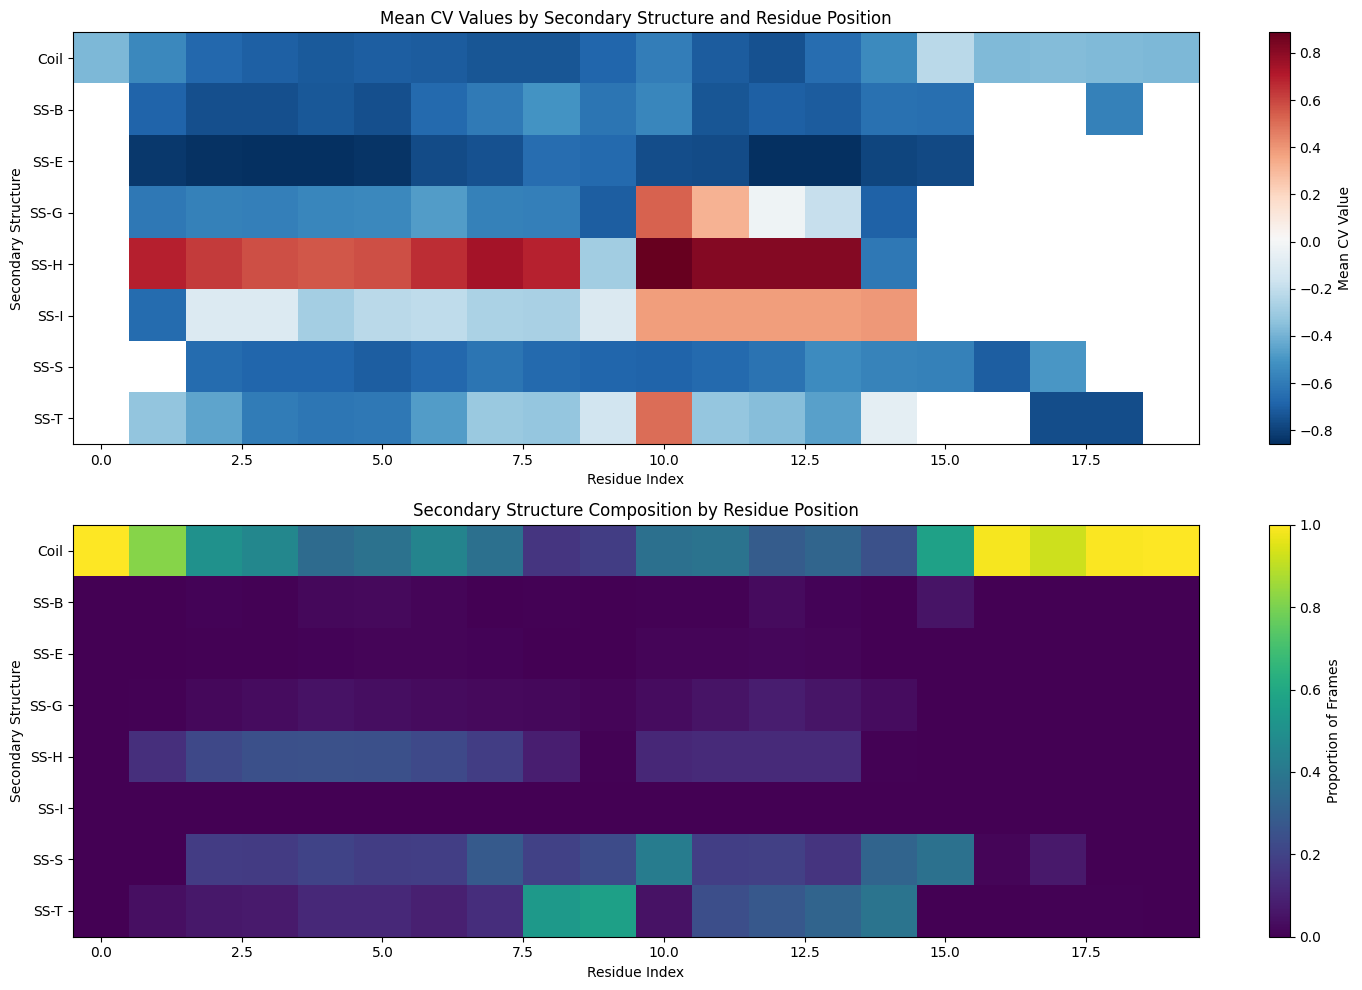


Statistical Analysis of CV by Secondary Structure:
One-way ANOVA:
  F-statistic: 1505476.0000
  P-value: 0.00e+00
  Significant difference: Yes

Pairwise CV Distribution Comparisons (t-tests):
--------------------------------------------------
SS-B vs SS-E:
  t-statistic: 199.1731
  p-value: 0.00e+00
  Significant: Yes

SS-B vs SS-G:
  t-statistic: -277.2018
  p-value: 0.00e+00
  Significant: Yes

SS-B vs SS-H:
  t-statistic: -1111.3590
  p-value: 0.00e+00
  Significant: Yes

SS-B vs SS-I:
  t-statistic: -214.2640
  p-value: 0.00e+00
  Significant: Yes

SS-B vs SS-S:
  t-statistic: -69.6638
  p-value: 0.00e+00
  Significant: Yes

SS-B vs SS-T:
  t-statistic: -263.3298
  p-value: 0.00e+00
  Significant: Yes

SS-E vs SS-G:
  t-statistic: -283.7140
  p-value: 0.00e+00
  Significant: Yes

SS-E vs SS-H:
  t-statistic: -945.4351
  p-value: 0.00e+00
  Significant: Yes

SS-E vs SS-I:
  t-statistic: -291.9362
  p-value: 0.00e+00
  Significant: Yes

SS-E vs SS-S:
  t-statistic: -200.0627
  p-va

: 

In [ ]:
## Comparative Analysis and Heatmap

# Create a heatmap showing mean CV values for each secondary structure at each residue
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Prepare data for heatmap
residue_range = range(dssp.shape[1])  # All residue positions
heatmap_data = np.full((len(ss_types), len(residue_range)), np.nan)
ss_type_labels = []

for ss_idx, ss_type in enumerate(ss_types):
    ss_name = 'Coil' if ss_type == ' ' else f'SS-{ss_type}'
    ss_type_labels.append(ss_name)
    
    for res_idx in residue_range:
        # Collect CV values for this residue when it has this secondary structure
        cv_values_for_residue = []
        
        for frame_idx in range(len(dssp)):
            if dssp[frame_idx, res_idx] == ss_type:
                cv_values_for_residue.append(cv[frame_idx, 0])  # Using first CV dimension
        
        if len(cv_values_for_residue) > 10:  # Minimum threshold for meaningful average
            heatmap_data[ss_idx, res_idx] = np.mean(cv_values_for_residue)

# Plot heatmap
im1 = ax1.imshow(heatmap_data, aspect='auto', cmap='RdBu_r', interpolation='nearest')
ax1.set_xlabel('Residue Index')
ax1.set_ylabel('Secondary Structure')
ax1.set_title('Mean CV Values by Secondary Structure and Residue Position')
ax1.set_yticks(range(len(ss_type_labels)))
ax1.set_yticklabels(ss_type_labels)

# Add colorbar
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Mean CV Value')

# Create a secondary structure composition plot
ss_composition = np.zeros((len(ss_types), dssp.shape[1]))

for res_idx in range(dssp.shape[1]):
    for frame_idx in range(len(dssp)):
        ss_type = dssp[frame_idx, res_idx]
        ss_idx = list(ss_types).index(ss_type)
        ss_composition[ss_idx, res_idx] += 1

# Normalize to get proportions
ss_composition = ss_composition / len(dssp)

# Plot composition
im2 = ax2.imshow(ss_composition, aspect='auto', cmap='viridis', interpolation='nearest')
ax2.set_xlabel('Residue Index')
ax2.set_ylabel('Secondary Structure')
ax2.set_title('Secondary Structure Composition by Residue Position')
ax2.set_yticks(range(len(ss_type_labels)))
ax2.set_yticklabels(ss_type_labels)

# Add colorbar
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('Proportion of Frames')

plt.tight_layout()
plt.show()

# Statistical analysis
print("\nStatistical Analysis of CV by Secondary Structure:")
print("=" * 65)

from scipy import stats

# Collect CV values for each secondary structure type
ss_cv_distributions = {}
for ss_type in ss_types:
	if ss_type == ' ':
		continue
	else:
		cv_values = []
		for frame_idx in range(len(dssp)):
			for res_idx in range(dssp.shape[1]):
				if dssp[frame_idx, res_idx] == ss_type:
					cv_values.append(cv[frame_idx, 0])
		if cv_values:
			ss_cv_distributions[ss_type] = np.array(cv_values)

# Perform ANOVA test
if len(ss_cv_distributions) > 1:
    # Prepare data for ANOVA
    anova_data = [values for values in ss_cv_distributions.values() if len(values) > 100]
    
    if len(anova_data) > 1:
        f_stat, p_value = stats.f_oneway(*anova_data)
        print(f"One-way ANOVA:")
        print(f"  F-statistic: {f_stat:.4f}")
        print(f"  P-value: {p_value:.2e}")
        print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
        print()

# Pairwise comparisons
print("Pairwise CV Distribution Comparisons (t-tests):")
print("-" * 50)

ss_types_with_data = [ss for ss in ss_types if ss in ss_cv_distributions and len(ss_cv_distributions[ss]) > 100]

for i, ss1 in enumerate(ss_types_with_data):
    for ss2 in ss_types_with_data[i+1:]:
        t_stat, p_val = stats.ttest_ind(ss_cv_distributions[ss1], ss_cv_distributions[ss2])
        ss1_name = 'Coil' if ss1 == ' ' else f'SS-{ss1}'
        ss2_name = 'Coil' if ss2 == ' ' else f'SS-{ss2}'
        
        print(f"{ss1_name} vs {ss2_name}:")
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value: {p_val:.2e}")
        print(f"  Significant: {'Yes' if p_val < 0.05 else 'No'}")
        print()

print("Analysis completed! 🎉")


# Conclusion